In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import argparse
import shutil
import time
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data.dataset import Dataset

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class imagenet_model():
    """
    ToDo. 
    """
    def __init__(self, name, pretrained):
        self.name = name
        self.pretrained = pretrained
        
        self._create_model()

        
    def _create_model(self):
        if self.pretrained:
            print("=> usinag pre-trained model '{}'".format(self.name))
            self.model = models.__dict__[self.name](pretrained=self.pretrained)
        else:
            print("=> creating model '{}'".format(self.name))
            self.model = models.__dict__[self.name]()

            
    def get_stats(self, img, label, temp=1000):
        with torch.no_grad():
            input_var = torch.autograd.Variable(img).cuda()
            out = nn.Softmax(dim=-1)(self.model(input_var)/temp)
            p, index = torch.max(out, dim=-1)
        return p.data.cpu().numpy(), index.data.cpu().numpy()

In [3]:
class get_args():
    def __init__(self):
        self.data = '/data/nvme/imagenet_data/raw-data/'
        self.batch_size = 64
        self.workers = 4
        self.input_size = 224
        
args = get_args()

In [4]:
#OOD data loaders
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_array, transform):
        self.data = data_array
        self.transform = transform
        self.data_len = len(self.data)

    def __getitem__(self, index):
        img_tensor = torch.from_numpy(self.data[index])
        image_label = torch.from_numpy(np.array([0]))
        return (self.transform(img_tensor), image_label)

    def __len__(self):
        return self.data_len


def create_ood_dataset_loader(name, transform, n_img=1000, tar_size=224, batch_size=64):
    """
    Creates dataloader for different OOD datasets. 
    """
    valid_datasets = ['imagenet', 'voc12', 'gaussian_noise', 'uniform_noise', 'random_photograph']
    assert name in valid_datasets
    
    #Image should be in uint8 format
    x_in = np.load('/data/nvme/datasets/random_images_picsum/random_images_train.npy')[0:n_img]
    assert x_in.dtype == 'uint8'
    
    x_in = np.transpose(x_in, (0, 3, 1, 2))  # NHWC -> NCHW conversion
    loader_ood = torch.utils.data.DataLoader(CustomDatasetFromImages(x_in, transform),
                                             batch_size=batch_size,
                                             shuffle=True)
    return loader_ood

# Data loading code
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(traindir, transforms.Compose([
        transforms.RandomResizedCrop(args.input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(256 if args.input_size<256 else 300),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True)

ood_transform = test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256 if args.input_size<256 else 300),
        transforms.CenterCrop(args.input_size),
        transforms.ToTensor(),
        normalize
    ])

ood_loader = create_ood_dataset_loader('random_photograph', ood_transform, 
                                       n_img=1000, tar_size=args.input_size, batch_size=args.batch_size)

In [9]:
m = imagenet_model('resnet152', pretrained=True)
m.model.cuda()
m.model.eval()

=> using pre-trained model 'resnet152'


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/vvikash/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:04<00:00, 49.8MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
fpr = []
temp = [1, 100, 1000]
for t in temp:
    # collect stats
    in_stats = []
    for i, (img, label) in enumerate(val_loader):
        p, _ = m.get_stats(img, label, t)
        in_stats += list(p)
        if i == 20:
            break

    ood_stats = []
    for i, (img, label) in enumerate(ood_loader):
        p, _ = m.get_stats(img, label, t)
        ood_stats += list(p)
    
    fpr_temp = []
    for i in range(100):
        th = np.percentile(in_stats, i)
        #print("for TPR = {}, OOD FPR = {}".format(100-i, np.sum(ood_stats > th)/len(ood_stats)))
        fpr_temp.append(np.sum(ood_stats > th)/len(ood_stats))
    fpr.append(fpr_temp)

0.06110285222530365
0.18052580669522286
0.23939720720052718
0.29027545511722563
0.32125215768814086
0.35914476960897446
0.39513153672218326
0.40955798894166945
0.4265842163562774
0.44923597782850266
0.467476961016655
0.48645403802394865
0.501143934726715
0.5141139501333236
0.5239144837856292
0.5435629725456238
0.552916100025177
0.5735138183832169
0.5908937966823578
0.6052650046348572
0.6219818472862244
0.6379591345787048
0.6546311676502228
0.6781179922819137
0.6962024211883544
0.7119845747947693
0.7277583265304566
0.738282430768013
0.7503269600868225
0.7596274024248123
0.7713543951511384
0.7838046944141388
0.7984788608551024
0.8074434483051299
0.8250536322593689
0.8343818366527557
0.8458596968650817
0.8583275514841079
0.8667004644870758
0.876384271979332
0.8834041118621827
0.8936574882268906
0.9031866002082825
0.9097238957881928
0.9158514881134033
0.9253591358661652
0.9315858352184296
0.9393025511503219
0.944722728729248
0.9509229755401611
0.9553711116313934
0.9602984952926635
0.962967

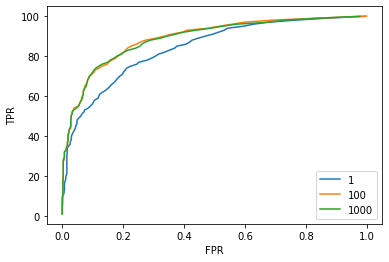

In [12]:
for i in range(len(temp)):
    plt.plot(fpr[i], 100-np.arange(100), label=temp[i])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend(loc='lower right')

In [ ]:
!pip 

In [ ]:
plt.hist(in_stats)

In [ ]:
plt.hist(ood_stats)